# Cross-section–recorded values (ray-tracing test)

This notebook runs ray tracing with **cross-section recording** enabled and plots the recorded cross-section ratio \(S\) (area change of a pencil of rays) along each ray.

In [9]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Use build_rays from this directory
sys.path.insert(0, str(Path.cwd()))
from build_rays import ray_trace, resample_to_xyz_cube
from psipy.model import MASOutput

PHI0_OFFSET = 24.0

%load_ext autoreload
%autoreload 2


# matplotlib inline

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Option A: Synthetic grid (no MAS model)

Build a small 3D grid of plasma frequency and run ray tracing with cross-section recording. No MAS data required.

In [56]:
# Grid and synthetic omega_pe (rad/s): smooth profile so rays propagate
grid_min, grid_max, grid_n = -2.0, 2.0, 80
x_grid = np.linspace(grid_min, grid_max, grid_n)
y_grid = np.linspace(grid_min, grid_max, grid_n)
z_grid = np.linspace(grid_min, grid_max, grid_n)

# omega_pe ~ 2*pi * 50 MHz at r=1, falling off with r
def make_omega_pe_3d(xg, yg, zg):
    xx, yy, zz = np.meshgrid(xg, yg, zg, indexing='ij')
    r = np.sqrt(xx**2 + yy**2 + zz**2)
    omega_pe = 2 * np.pi * 82e6 * np.exp(-0.6 * (r - 1.0))
    return np.where(r >= 0.95, omega_pe, np.nan)

omega_pe_3d = make_omega_pe_3d(x_grid, y_grid, z_grid)
omega_pe_3d = np.where(np.isfinite(omega_pe_3d), omega_pe_3d, 0.0)

freq_hz = 75e6
n_rays = 12
z_start = np.linspace(-1.2, 1.2, n_rays)
x_start = np.full_like(z_start, 1.95)
y_start = np.zeros_like(z_start)
kvec_in_norm = np.tile([[-1, 0, 0]], (n_rays, 1))

r_record, crosssection_record = ray_trace(
    omega_pe_3d=omega_pe_3d,
    x_grid=x_grid,
    y_grid=y_grid,
    z_grid=z_grid,
    freq_hz=freq_hz,
    x_start=x_start,
    y_start=y_start,
    z_start=z_start,
    kvec_in_norm=kvec_in_norm,
    dt=8e-3,
    n_steps=4000,
    record_stride=8,
    trace_crosssections=True,
    perturb_ratio=2,
)

# Stack to (n_records, n_rays)
S_arr = np.array(crosssection_record)
print("r_record shape:", r_record.shape)
print("crosssection_record length:", len(crosssection_record))
print("S_arr shape:", S_arr.shape)

r_record shape: (500, 12, 3)
crosssection_record length: 500
S_arr shape: (500, 12)


## Plots: cross-section ratio along rays

- **S_ratio**: ratio of cross-sectional area (from perturbed rays) to the reference area \(\varepsilon^2\) (set by the initial perturbation scale). So \(S \approx 1\) where the pencil is unchanged, \(S < 1\) means focusing (narrower pencil), \(S > 1\) means defocusing (wider pencil).

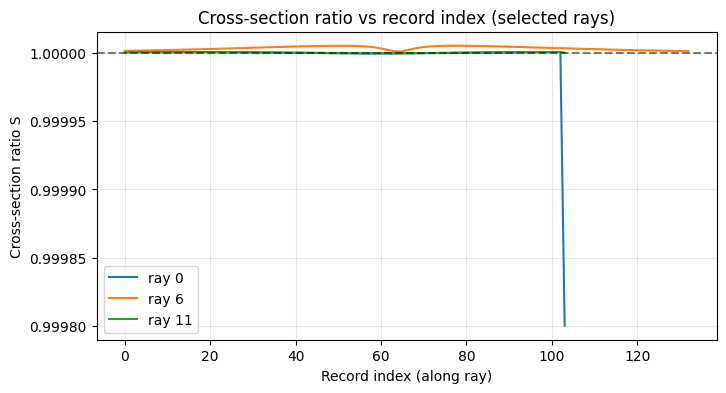

In [57]:
# 1) S_ratio vs record index for a few rays
record_idx = np.arange(S_arr.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in [0, n_rays // 2, n_rays - 1]:
    ax.plot(record_idx, S_arr[:, i], label=f"ray {i}")
ax.axhline(1.0, color="k", linestyle="--", alpha=0.5)
ax.set_xlabel("Record index (along ray)")
ax.set_ylabel("Cross-section ratio S")
ax.set_title("Cross-section ratio vs record index (selected rays)")
ax.legend()
ax.grid(True, alpha=0.3)


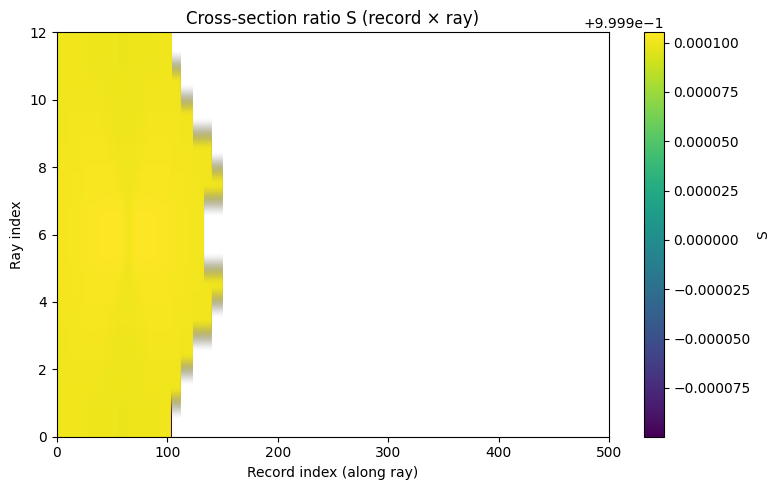

In [58]:
# 2) Heatmap: record index vs ray index
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
im = ax.imshow(S_arr.T, aspect="auto", origin="lower",
               extent=[0, S_arr.shape[0], 0, S_arr.shape[1]],
               cmap="viridis")
ax.set_xlabel("Record index (along ray)")
ax.set_ylabel("Ray index")
ax.set_title("Cross-section ratio S (record × ray)")
plt.colorbar(im, ax=ax, label="S")
plt.tight_layout()
plt.show()

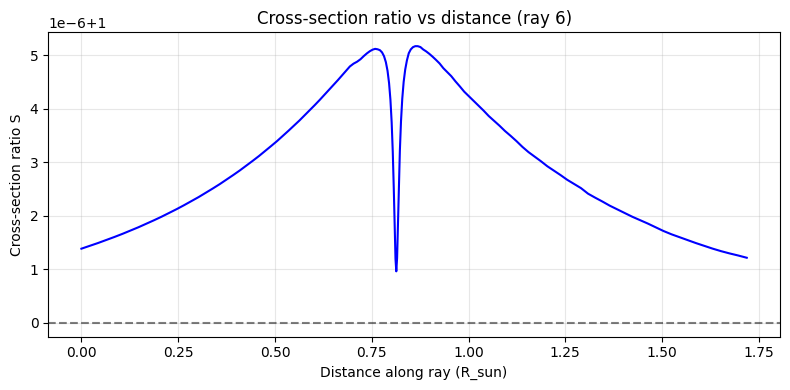

In [59]:
# 3) Distance along ray (from start) vs S for central ray
ray_id = n_rays // 2
r_ray = r_record[:, ray_id, :]  # (n_records, 3)
dr = np.linalg.norm(np.diff(r_ray, axis=0), axis=1)
dist = np.concatenate([[0], np.cumsum(dr)])
S_ray = S_arr[:, ray_id]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(dist, S_ray, "b-")
ax.axhline(1.0, color="k", linestyle="--", alpha=0.5)
ax.set_xlabel("Distance along ray (R_sun)")
ax.set_ylabel("Cross-section ratio S")
ax.set_title(f"Cross-section ratio vs distance (ray {ray_id})")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Rays on Ne map (grayscale, rays colored by S−1)

x–z slice of electron density \(N_e\) in grayscale with ray paths overplotted; each ray segment is colored by \(S-1\) (bwr: blue = focusing, white = unchanged, red = defocusing).

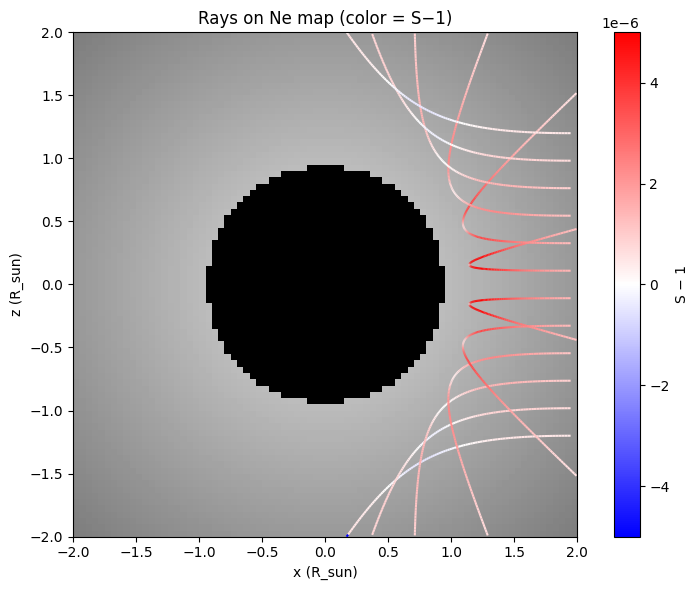

In [60]:
from matplotlib.collections import LineCollection

# Ne (cm^-3) from omega_pe: omega_pe = 8.93e3 * sqrt(Ne) * 2*pi
Ne_3d = (omega_pe_3d / (2 * np.pi) / 8.93e3) ** 2
y_index = len(y_grid) // 2
Ne_slice = Ne_3d[:, y_index, :].T  # (nz, nx) for imshow

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log10(Ne_slice + 1e-30), extent=[x_grid[0], x_grid[-1], z_grid[0], z_grid[-1]],
          origin="lower", cmap="gray", aspect="auto",vmin=5, vmax=9)

# LineCollection: one segment per (j -> j+1) per ray, color = S-1
S_minus_1 = S_arr - 1.0
v = np.nanmax(np.abs(S_minus_1))
v = min(v, 5e-6)
norm = plt.Normalize(vmin=-v, vmax=+v)
cmap = plt.get_cmap("bwr")

for i in range(n_rays):
    x_ray = r_record[:, i, 0]
    z_ray = r_record[:, i, 2]
    valid = np.isfinite(x_ray) & np.isfinite(z_ray)
    if not np.any(valid):
        continue
    pts = np.column_stack([x_ray, z_ray])
    segs = np.stack([pts[:-1], pts[1:]], axis=1)
    # color each segment by S-1 at segment start (or average)
    vals = 0.5 * (S_minus_1[:-1, i] + S_minus_1[1:, i])
    lc = LineCollection(segs, array=vals, norm=norm, cmap=cmap, linewidths=1.5)
    ax.add_collection(lc)

ax.autoscale()
ax.set_xlim(x_grid[0], x_grid[-1])
ax.set_ylim(z_grid[0], z_grid[-1])
ax.set_xlabel("x (R_sun)")

ax.set_aspect("equal")
ax.set_ylabel("z (R_sun)")
ax.set_title("Rays on Ne map (color = S−1)")
cb = plt.colorbar(lc, ax=ax, label="S − 1")
plt.tight_layout()
plt.show()

## Optional: run with MAS model (if `./corona` exists)

If you have a MAS model at `./corona`, the cell below resamples it, runs ray tracing with cross-section recording, and plots the same diagnostics.

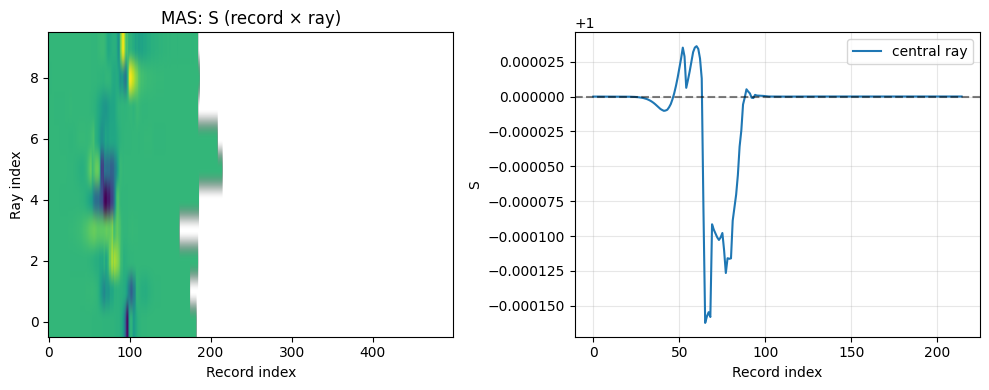

In [45]:
model_path = Path("./corona")
if True:
    model = MASOutput(str(model_path))
    grid_n_mas = 120
    xg = np.linspace(-3, 3, grid_n_mas)
    yg = np.linspace(-3, 3, grid_n_mas)
    zg = np.linspace(-3, 3, grid_n_mas)
    rhoxyz = resample_to_xyz_cube(model, "rho", xg, yg, zg, phi0_offset=PHI0_OFFSET,
                                   fill_nan=0.0, verbose=False)
    omega_pe_mas = 8.93e3 * np.sqrt(rhoxyz) * 2 * np.pi

    n_rays_mas = 10
    zs = np.linspace(-1.0, 1.0, n_rays_mas)
    xs = np.full_like(zs, 2.9)
    ys = np.zeros_like(zs)
    kvec = np.tile([[-1, 0, 0]], (n_rays_mas, 1))

    r_rec, cs_rec = ray_trace(omega_pe_mas, xg, yg, zg, 75e6, xs, ys, zs, kvec,
                              dt=6e-3, n_steps=5000, record_stride=10,
                              trace_crosssections=True, perturb_ratio=2)
    S_mas = np.array(cs_rec)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(S_mas.T, aspect="auto", origin="lower", cmap="viridis")
    axes[0].set_xlabel("Record index"); axes[0].set_ylabel("Ray index")
    axes[0].set_title("MAS: S (record × ray)")
    axes[1].plot(S_mas[:, n_rays_mas // 2], label="central ray")
    axes[1].axhline(1.0, color="k", ls="--", alpha=0.5)
    axes[1].set_xlabel("Record index"); axes[1].set_ylabel("S")
    axes[1].legend(); axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

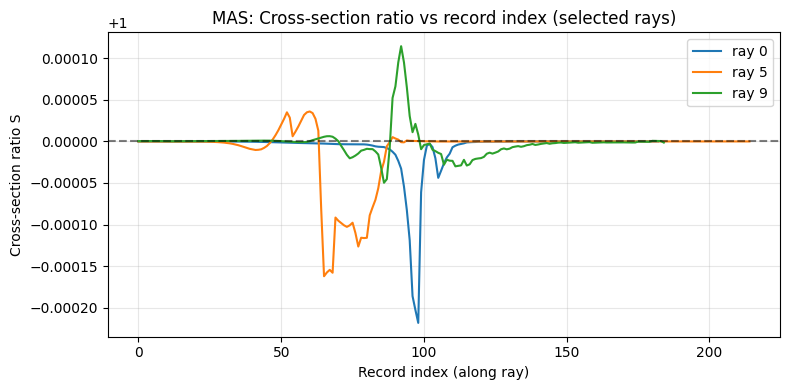

In [46]:
# MAS: S_ratio vs record index for selected rays (same style as synthetic)
# Run the "Optional: run with MAS model" cell first so S_mas, n_rays_mas exist.
record_idx_mas = np.arange(S_mas.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i in [0, n_rays_mas // 2, n_rays_mas - 1]:
    ax.plot(record_idx_mas, S_mas[:, i], label=f"ray {i}")
ax.axhline(1.0, color="k", linestyle="--", alpha=0.5)
ax.set_xlabel("Record index (along ray)")
ax.set_ylabel("Cross-section ratio S")
ax.set_title("MAS: Cross-section ratio vs record index (selected rays)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

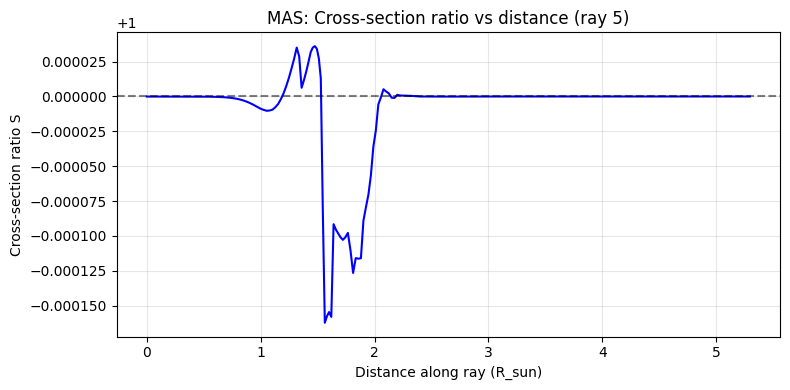

In [47]:
# MAS: S vs distance along ray for central ray (same style as synthetic)
ray_id_mas = n_rays_mas // 2
r_ray_mas = r_rec[:, ray_id_mas, :]
dr_mas = np.linalg.norm(np.diff(r_ray_mas, axis=0), axis=1)
dist_mas = np.concatenate([[0], np.cumsum(dr_mas)])
S_ray_mas = S_mas[:, ray_id_mas]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(dist_mas, S_ray_mas, "b-")
ax.axhline(1.0, color="k", linestyle="--", alpha=0.5)
ax.set_xlabel("Distance along ray (R_sun)")
ax.set_ylabel("Cross-section ratio S")
ax.set_title(f"MAS: Cross-section ratio vs distance (ray {ray_id_mas})")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

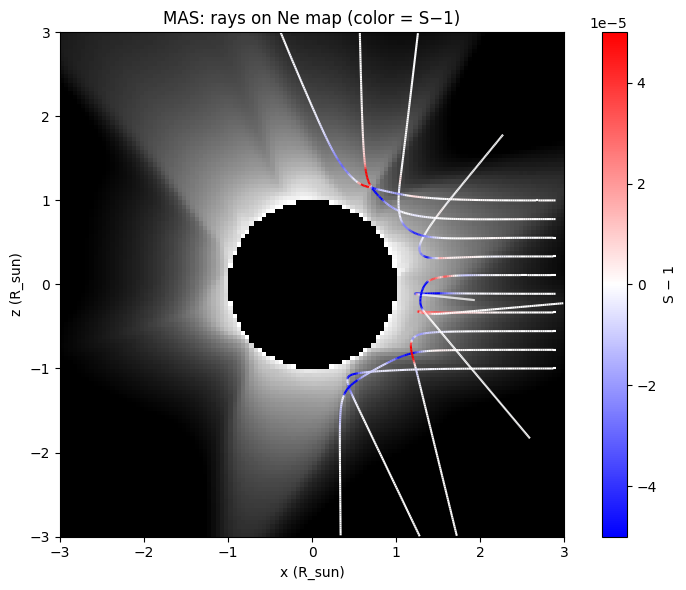

In [53]:
# Rays on Ne map (MAS): grayscale Ne + rays colored by S−1 (bwr)
# Run the "Optional: run with MAS model" cell first so r_rec, S_mas, omega_pe_mas, xg, zg, n_rays_mas exist.
from matplotlib.collections import LineCollection

Ne_mas = (omega_pe_mas / (2 * np.pi) / 8.93e3) ** 2
y_idx_mas = len(yg) // 2
Ne_slice_mas = Ne_mas[:, y_idx_mas, :].T

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(np.log10(Ne_slice_mas + 1e-30), extent=[xg[0], xg[-1], zg[0], zg[-1]],
          origin="lower", cmap="gray", aspect="auto", vmin=5, vmax=9)

S_m1_mas = S_mas - 1.0
v_mas = np.nanmax(np.abs(S_m1_mas))
v_mas = min(v_mas, 5e-5)
norm_mas = plt.Normalize(vmin=-v_mas, vmax=+v_mas)
cmap_bwr = plt.get_cmap("bwr")

for i in range(n_rays_mas):
    x_ray = r_rec[:, i, 0]
    z_ray = r_rec[:, i, 2]
    valid = np.isfinite(x_ray) & np.isfinite(z_ray)
    if not np.any(valid):
        continue
    pts = np.column_stack([x_ray, z_ray])
    segs = np.stack([pts[:-1], pts[1:]], axis=1)
    vals = 0.5 * (S_m1_mas[:-1, i] + S_m1_mas[1:, i])
    lc = LineCollection(segs, array=vals, norm=norm_mas, cmap=cmap_bwr, linewidths=1.5)
    ax.add_collection(lc)

ax.autoscale()
ax.set_xlim(xg[0], xg[-1])
ax.set_ylim(zg[0], zg[-1])
ax.set_xlabel("x (R_sun)")
ax.set_ylabel("z (R_sun)")
ax.set_title("MAS: rays on Ne map (color = S−1)")
cb = plt.colorbar(lc, ax=ax, label="S − 1")


# axis equal
ax.set_aspect("equal")

plt.tight_layout()
plt.show()